<center>
<font size="6">Active learning and dimensionality reduction</font><br>
<font size="4">Fish classification and weight estimation</font>
    </center>

# README
This notebook stores the evaluation result of active learning with dimension reduction by autoencoders.

In [80]:
# import needed libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import pairwise_distances
from matplotlib.colors import ListedColormap
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import PCA
from sklearn import tree
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDRegressor
from numpy.linalg import svd
!pip install umap-learn
import umap
from sklearn.manifold import TSNE

# create a random seed to ensure reproducibility
general_seed=11
np.random.seed(general_seed)

Defaulting to user installation because normal site-packages is not writeable


We will load the data from a GIT repository. After running, the data will be availabe in the subdirectoy `data`.

In [81]:
!git clone https://git.wur.nl/manuel.cordovaneira/project_active_learning.git data 

fatal: destination path 'data' already exists and is not an empty directory.


In [82]:
# load data
all_features_2d = np.load('data/crop_features/features_2216_2_with_labels.npy')
all_features_10d= np.load('data/crop_features/features_2216_10_with_labels.npy')
all_features_20d= np.load('data/crop_features/features_2216_20_with_labels.npy')
all_features_512d= np.load('data/crop_features/features_2216_512_with_labels.npy')

# Part 0: Explore the data

There are 2216 samples. The first feature is the name of sample. The second and the third features are the PCA components, the fourth feature is the class of the fish, and the last feature is the weight of the fish.

In [83]:
# convert the data to a pandas dataframe
pd_all_features_2d= pd.DataFrame(all_features_2d)
pd_all_features_10d= pd.DataFrame(all_features_10d)
pd_all_features_20d= pd.DataFrame(all_features_20d)
pd_all_features_512d= pd.DataFrame(all_features_512d)
# remove the first column, which is the name of the sample
pd_all_features_2d = pd_all_features_2d.drop(0, axis=1)
pd_all_features_10d = pd_all_features_10d.drop(0, axis=1)
pd_all_features_20d = pd_all_features_20d.drop(0, axis=1)
pd_all_features_512d = pd_all_features_512d.drop(0, axis=1)
# Rename the last two columns with correct names
pd_all_features_2d.rename(columns={pd_all_features_2d.columns[-2]: 'species', pd_all_features_2d.columns[-1]: 'weight'}, inplace=True)
pd_all_features_10d.rename(columns={pd_all_features_10d.columns[-2]: 'species', pd_all_features_10d.columns[-1]: 'weight'}, inplace=True)
pd_all_features_20d.rename(columns={pd_all_features_20d.columns[-2]: 'species', pd_all_features_20d.columns[-1]: 'weight'}, inplace=True)
pd_all_features_512d.rename(columns={pd_all_features_512d.columns[-2]: 'species', pd_all_features_512d.columns[-1]: 'weight'}, inplace=True)

In [84]:
# convert all the data to float,except the species
pd_all_features_2d = pd_all_features_2d.astype(float)
pd_all_features_10d = pd_all_features_10d.astype(float)
pd_all_features_20d = pd_all_features_20d.astype(float)
pd_all_features_512d = pd_all_features_512d.astype(float)
pd_all_features_2d['species'] = pd_all_features_2d['species'].astype('category')
pd_all_features_10d['species'] = pd_all_features_10d['species'].astype('category')
pd_all_features_20d['species'] = pd_all_features_20d['species'].astype('category')
pd_all_features_512d['species'] = pd_all_features_512d['species'].astype('category')

In [85]:
# apply standard scaling to the features, except the species and weight
scaler = StandardScaler()
pd_all_features_2d.iloc[:, :-2] = scaler.fit_transform(pd_all_features_2d.iloc[:, :-2])
pd_all_features_10d.iloc[:, :-2] = scaler.fit_transform(pd_all_features_10d.iloc[:, :-2])
pd_all_features_20d.iloc[:, :-2] = scaler.fit_transform(pd_all_features_20d.iloc[:, :-2])
pd_all_features_512d.iloc[:, :-2] = scaler.fit_transform(pd_all_features_512d.iloc[:, :-2])

# Part 1: Process data and define functions

## Define Commonly used functions

In [86]:
# define the commonly used operations
def get_features(df,columns_to_delete = ['species', 'weight']):
    return df.drop(columns=[col for col in columns_to_delete if col in df])
def get_label(df, name="species"):
    return df[name]

## 1.1: split data

In [87]:
#Step 1: Split the data

#Define a function to split data into a initial training set, a unlabelled pool, and a test set.
def al_split_data(my_data, train_size, test_size):
    assert len(my_data) - train_size - test_size > 0
    # First split of a test set
    if(my_data.species.dtype.name == 'category'):
        my_data, test_data = train_test_split(my_data, test_size=test_size, stratify=my_data['species'],random_state=general_seed)
    else:
        my_data, test_data = train_test_split(my_data, test_size=test_size,random_state=general_seed)
    # Then split of a small training set and leave the rest in the unlabelled pool
    if(my_data.species.dtype.name == 'category'):
        train_data, unlabelled_data = train_test_split(my_data, train_size=train_size, stratify=my_data['species'],random_state=general_seed)
    else:
        train_data, unlabelled_data = train_test_split(my_data, train_size=train_size,random_state=general_seed)     
        
    train_data.reset_index(drop=True, inplace=True)
    unlabelled_data.reset_index(drop=True, inplace=True)

    return train_data, unlabelled_data, test_data


## 1.2 : train classifier

In [88]:
#Step 2: Train a classifier

#Define a function to plot the decisionboundary
def plotClassificationOutput2D_AL(clf, data, unlabelled_data=None, selected_data=None):
    if(unlabelled_data is not None):
        data_X = pd.concat([data[['PC1','PC2']],unlabelled_data[['PC1','PC2']]])
    else:
        data_X =get_features(data)
        
    
    _, ax = plt.subplots()
    DecisionBoundaryDisplay.from_estimator(
        clf, data_X, cmap='tab10', alpha=0.5, ax=ax,
        response_method="predict", plot_method="pcolormesh",
        xlabel='PC1', ylabel='PC2', shading="auto",
    )

    sns.scatterplot(data=data, x='PC1', y='PC2', hue='species', palette='tab10', alpha=1.0, edgecolor="black")
    plt.legend(title='Species', facecolor='white', frameon=True)
    if(unlabelled_data is not None):
        sns.scatterplot(data=unlabelled_data, x='PC1', y='PC2', color='black', s=8)
    if(selected_data is not None):
        sns.scatterplot(data=selected_data, x='PC1', y='PC2', color='white', s=30, alpha=1.0, edgecolor="white", linewidth=1, legend=False)



## 1.3 random sampling

In [89]:
#Step 3: A function that randomly samples from the data
def al_sampling_random(unlabelled_data, n_samples):
    assert len(unlabelled_data) >  n_samples
    sample_idx = np.random.choice(len(unlabelled_data), n_samples)  # Random set of samples
    unlabelled_sample = unlabelled_data.iloc[sample_idx,:]          # Get the samples
    return unlabelled_sample, sample_idx, None

## 1.4 Iterative Active Learning

In [90]:
#Step 4: Iterative Active learning

#-----------------------------------------Metric support functions-----------------------------------------
# Function calculation diversity for most-diverse sampling

def get_div_knn(clf, data, C):
    X = get_features(data)
    dist, _ = clf.kneighbors(X)        # 1. Get the distance to all k neighbors for all samples X
    dist_mean = np.mean(dist, axis=1)  # 2. Get the mean distance to the neighbors per sample
    div = dist_mean / dist_mean.max()  # 3. Normalize the distances from 0 to 1    
    return div

def get_div_sgd(clf, data, C):
    X = get_features(data)
    distances = pairwise_distances(X)  # 1. Compute pairwise distances among all samples
    dist_mean = np.mean(distances, axis=1)  # 2. Get the mean distance to all other samples for each sample
    div = dist_mean / dist_mean.max()  # 3. Normalize the distances from 0 to 1 
    return div

## Function calculating uncertainty for Least-certainty sampling 
def get_unc_lc(clf, data, C):
    X = get_features(data)
    pred_prob = clf.predict_proba(X)               # 1.Calculate the probabilities per class for all samples 
    unc = (1 - pred_prob.max(axis=1))*C/(C-1)      # 2.Calculate the uncertainty
    return unc



def getPerformance(clf, data, metric = "f1_micro", name = "species"): 
    # F1, to deal with imbalanced data set
    # micro, to take the class distribution of dataset into account
    data_X, data_y = get_features(data), get_label(data,name = name)
    pred_y = clf.predict(data_X)
    if name == "weight":
        performance = mean_squared_error(data_y, pred_y)
    else:
        if metric == "f1_macro":
            performance = f1_score(data_y,pred_y, average = "macro")
        elif metric == 'f1_micro':
            performance = f1_score(data_y,pred_y, average = "micro")
        elif metric == 'acc':
            performance = accuracy_score(data_y, pred_y)

    return(performance)


#-----------------------------------------Active learning functions-----------------------------------------

#Function to add the sampled data to the train_data pool
def al_add_training_data(train_data, unlabelled_data, unlabelled_sample, sample_idx):
    # Add the sample to the training data
    
    train_data = pd.concat([train_data, unlabelled_sample])
    train_data.reset_index(drop=True, inplace=True)
    # Remove the sample from the unlabelled data
    unlabelled_data.drop(sample_idx, inplace=True)
    unlabelled_data.reset_index(drop=True, inplace=True)
    return train_data, unlabelled_data


#Function to train a machine learning classifier and test it on the test_data
def al_train_and_test(clf, train_data, test_data, show=False, name = "species"):
    train_X,train_y=get_features(train_data),get_label(train_data, name)#train_data['species']
    clf.fit(train_X, train_y)

    if(show):
        # Plot the classification boundary and the test data
        plotClassificationOutput2D_AL(clf, test_data)
        plt.title('Classification boundary and the test data')
        plt.show()

    # Get the performance 
    if name == "species":
        test_acc = getPerformance(clf, test_data)
    elif name == "weight":
        test_acc = getPerformance(clf, test_data, metric = "acc", name = "weight")
    return(test_acc)

#Function to sample new data from the unlabbeled data pool based on uncertainty
def al_sampling_unc(clf, sample_score_fnc, unlabelled_data, n_samples, name = "species"):
    n = min(n_samples, len(unlabelled_data))
    if(n>0):
        unc = sample_score_fnc(clf, unlabelled_data, C=len(clf.classes_) if name == "species" else None)
        sort_idx = np.argsort(unc, )[::-1]                # 3.Sort samples in descending order based on uncertainty
        t5_idx = sort_idx[0:n]                              # 4.Select the top 5 most uncertain samples     
        unlabelled_sample = unlabelled_data.iloc[t5_idx,:]  # 5.Get the sample
        return unlabelled_sample, t5_idx, unc[t5_idx]
    else:
        return None,None,None 

def run_al(sample_score_fnc, clf, train_data0, unlabelled_data0, test_data0, n_samples, N, combine = False, name = "species" ):
    test_accuracy = []
    # Make a copy of the initial sets, so that AL and random selection work on the same initial data
    train_data = train_data0.copy()
    unlabelled_data = unlabelled_data0.copy()
    test_data = test_data0.copy()

    test_acc = al_train_and_test(clf, train_data, test_data, show=False, name = name)
    test_accuracy.append(test_acc)
    for it in range(N):
        if combine:
            #Uncertainty sampling and training on 1/2 data
            unlabelled_sample, sample_idx, sample_unc = al_sampling_unc(clf,sample_score_fnc,unlabelled_data=unlabelled_data,n_samples=n_samples // 2, name = name)
            train_data, unlabelled_data = al_add_training_data(train_data,unlabelled_data, unlabelled_sample,sample_idx)
            #Diversity sampling and training on other 1/2 data
            unlabelled_sample, sample_idx, sample_div = al_sampling_unc(clf,sample_score_fnc,unlabelled_data=unlabelled_data,n_samples=n_samples // 2, name = name)
            train_data, unlabelled_data = al_add_training_data(train_data,unlabelled_data, unlabelled_sample,sample_idx)
        else:
            #Uncertainty sampling and training
            unlabelled_sample, sample_idx, sample_unc = al_sampling_unc(clf,sample_score_fnc,unlabelled_data=unlabelled_data,n_samples=n_samples, name = name)
            train_data, unlabelled_data = al_add_training_data(train_data,unlabelled_data, unlabelled_sample,sample_idx)
        
        test_acc = al_train_and_test(clf,train_data,test_data, name = name)

        test_accuracy.append(test_acc)
    return(test_accuracy, train_data, unlabelled_data)

def mean_std(data):
    data = np.array(data)
    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    return mean, std




## 1.5 Compare with random sampling

In [91]:
#Step 5: Compare with the random sampling method

def al_sampling_random(unlabelled_data, n_samples):
    assert len(unlabelled_data) >  n_samples
    sample_idx = np.random.choice(len(unlabelled_data), n_samples)  # Random set of samples
    unlabelled_sample = unlabelled_data.iloc[sample_idx,:]          # Get the samples
    return unlabelled_sample, sample_idx, None

# Random learning
def run_random(clf, train_data0, unlabelled_data0, test_data0, n_samples, N):
    test_accuracy = []
    # Make a copy of the initial sets, so that AL and random selection work on the same initial data
    train_data = train_data0.copy()
    unlabelled_data = unlabelled_data0.copy()
    test_data = test_data0.copy()

    test_acc = al_train_and_test(clf, train_data, test_data, show=False)
    test_accuracy.append(test_acc)
    for it in range(N):
        unlabelled_sample, sample_idx, sample_unc = al_sampling_random(unlabelled_data, n_samples) 
        train_data, unlabelled_data = al_add_training_data(train_data, unlabelled_data, unlabelled_sample, sample_idx)

        test_acc = al_train_and_test(clf, train_data, test_data, show=False)
        test_accuracy.append(test_acc)
    return(test_accuracy, train_data, unlabelled_data)


## 1.6 Compare different methods of Uncertainty Sampling

In [92]:


## Function calculating uncertainty for Margin of confidence sampling
def get_unc_mc(clf, data, C):
    X = get_features(data)
    pred_prob = clf.predict_proba(X)               # 1.Calculate the probabilities per class for all samples 
    p_sorted = np.sort(pred_prob, axis=1)[:,::-1]  # 2. Sort the probabilities per row in decending order
    unc = 1 - (p_sorted[:,0] - p_sorted[:,1])      # 3.Calculate the uncertainty
    return unc

## Function calculating uncertainty for Ratio sampling
def get_unc_rs(clf, data, C):
    X = get_features(data)
    pred_prob = clf.predict_proba(X)               # 1.Calculate the probabilities per class for all samples 
    p_sorted = np.sort(pred_prob, axis=1)[:,::-1]  # 2. Sort the probabilities per row in decending order
    unc = p_sorted[:,1] / p_sorted[:,0]            # 3.Calculate the uncertainty
    return unc



# Part 2: Classification with 2 features extracted by autoencoder

## 2.1 Prepare data

In [93]:
#Step 1: Prepare the data
train_data_all, unlabelled_data_all, test_data_all = al_split_data(pd_all_features_2d, train_size= 0.01, test_size=0.20)
dev_data_all=pd.concat([train_data_all,unlabelled_data_all],axis=0)
data_list_all = ['train_data_all', 'unlabelled_data_all', 'test_data_all','dev_data_all']

# Loop over the data variables to get features and labels
for data_name in data_list_all:
    exec(f"{data_name}_X = get_features({data_name})")
    exec(f"{data_name}_y = get_label({data_name})")


## 2.2 Train a classifier with all data

In [94]:
#Step 2: Train the classifier with all data
#Train a classifier
model_all = SGDClassifier(max_iter=1000, tol=1e-3, loss='log_loss')
model_all.fit(dev_data_all_X, dev_data_all_y)
#Print the different evaluation metrics
print("Prediction on training \ndata accuracy: {},\nrecall:{},\nprecision:{},\nf1 macro: {},\nf1 micro: {} ".format(accuracy_score(dev_data_all_y, model_all.predict(dev_data_all_X)),
precision_score(dev_data_all_y, model_all.predict(dev_data_all_X),average='micro'),
recall_score(dev_data_all_y, model_all.predict(dev_data_all_X),average='micro'),
f1_score(dev_data_all_y, model_all.predict(dev_data_all_X), average ='macro'),
f1_score(dev_data_all_y, model_all.predict(dev_data_all_X), average ='micro')))

Prediction on training 
data accuracy: 0.5400677200902935,
recall:0.5400677200902935,
precision:0.5400677200902935,
f1 macro: 0.0870967542559711,
f1 micro: 0.5400677200902935 


## 2.3 Random sampling(skipped)

## 2.4 Iterative active learning(skipped)

## 2.5  Compare random sampling

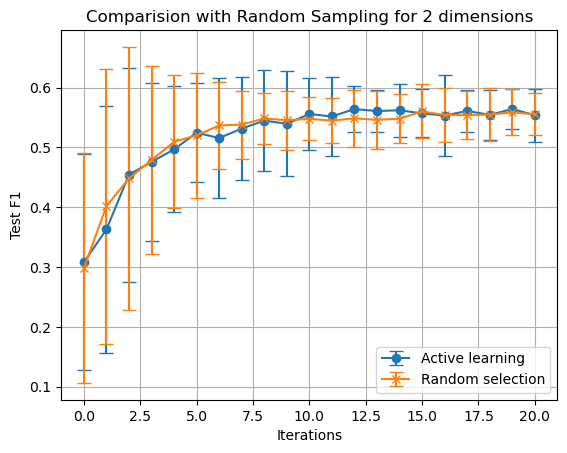

Test F1 Macro for lc: 0.5563063063063063, rand: [0.4099099099099099, 0.24774774774774774, 0.5337837837837838, 0.5067567567567568, 0.5472972972972973, 0.5720720720720721, 0.5675675675675675, 0.5765765765765766, 0.5337837837837838, 0.5337837837837838, 0.5405405405405406, 0.5337837837837838, 0.5765765765765766, 0.5540540540540541, 0.5180180180180181, 0.5720720720720721, 0.5855855855855856, 0.5563063063063063, 0.5337837837837838, 0.581081081081081, 0.5337837837837838]


In [95]:
#Step 3 skip
#Step 4 itterative active learning
#Step 5: Compare least uncertainty sampling with random sampling
np.seterr(divide='ignore', invalid='ignore')

sample_factor = 0.05
N = int(1/sample_factor)
n_samples = int(unlabelled_data_all.shape[0]*sample_factor)

test_performance_al = []
test_performance_rand = []

#Perform active learning with different sampling starts
num_seeds = 30 
for seed in range(num_seeds):
    np.random.seed(seed)
    test_accuracy_al, train_data_al, _ = run_al(get_unc_lc, model_all, train_data_all, unlabelled_data_all, test_data_all, n_samples, N)
    test_accuracy_rand, _, _ = run_random(model_all, train_data_all, unlabelled_data_all, test_data_all, n_samples, N)
    test_performance_al.append(test_accuracy_al)
    test_performance_rand.append(test_accuracy_rand)

#Calculate the mean and standard deviation of the data
mean_lc, std_lc = mean_std(test_performance_al)
mean_rand, std_rand = mean_std(test_performance_rand)

# Plotting with confidence intervals 95%
ci_lc = 1.96 * std_lc
ci_rand = 1.96 * std_rand

plt.errorbar(range(N+1), mean_lc, yerr=ci_lc, fmt='o-', capsize=5)
plt.errorbar(range(N+1), mean_rand, yerr=ci_rand, fmt='x-', capsize=5)
plt.xlabel('Iterations')
plt.ylabel('Test F1')
plt.title('Comparision with Random Sampling for 2 dimensions')
plt.legend(['Active learning','Random selection'])
plt.grid()
plt.show()

#Calculating the performance with the new trainingset
test_acc_lc = al_train_and_test(model_all, train_data_al, test_data_all, show=False)
print("Test F1 Macro for lc: {}, rand: {}".format(test_acc_lc, test_accuracy_rand ))


## 2.6 Compare different uncertainty sampling methods

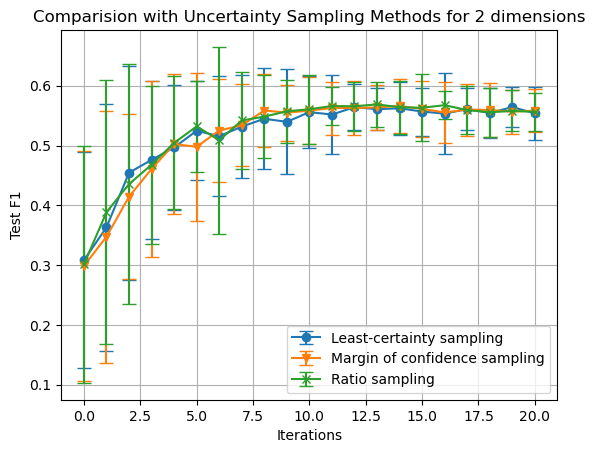

Test F1 Macro for lc: 0.5337837837837838, mc: 0.5720720720720721, rs 0.5563063063063063


In [96]:
#Step 6: Compare the different types of uncertainty sampling

test_performance_lc = []
test_performance_mc = []
test_performance_rs = []

#Perform active learning with different sampling starts

num_seeds = 30
for seed in range(num_seeds):
    np.random.seed(seed)
    test_accuracy_al_lc, train_data_al_lc, _ = run_al(get_unc_lc, model_all, train_data_all, unlabelled_data_all, test_data_all, n_samples, N)
    test_accuracy_al_mc, train_data_al_mc, _ = run_al(get_unc_mc, model_all, train_data_all, unlabelled_data_all, test_data_all, n_samples, N)
    test_accuracy_al_rs, train_data_al_rs, _ = run_al(get_unc_rs, model_all, train_data_all, unlabelled_data_all, test_data_all, n_samples, N)

    test_performance_lc.append(test_accuracy_al_lc)
    test_performance_mc.append(test_accuracy_al_mc)
    test_performance_rs.append(test_accuracy_al_rs)

#Calculate the mean and standard deviation of the data
mean_lc, std_lc = mean_std(test_performance_lc)
mean_mc, std_mc = mean_std(test_performance_mc)
mean_rs, std_rs = mean_std(test_performance_rs)

# Plotting with confidence intervals 95%
ci_lc = 1.96 * std_lc
ci_mc = 1.96 * std_mc
ci_rs = 1.96 * std_rs

plt.errorbar(range(N+1), mean_lc, yerr=ci_lc, fmt='o-', capsize=5)
plt.errorbar(range(N+1), mean_mc, yerr=ci_mc, fmt='v-', capsize=5)
plt.errorbar(range(N+1), mean_rs, yerr=ci_rs, fmt='x-', capsize=5)

plt.xlabel('Iterations')
plt.ylabel('Test F1')
plt.title('Comparision with Uncertainty Sampling Methods for 2 dimensions')
plt.legend(['Least-certainty sampling ','Margin of confidence sampling','Ratio sampling'])
plt.grid()
plt.show()

#Calculating the performance with the new trainingset
test_acc_lc = al_train_and_test(model_all, train_data_al_lc, test_data_all, show=False)
test_acc_mc = al_train_and_test(model_all, train_data_al_mc, test_data_all, show=False)
test_acc_rs = al_train_and_test(model_all, train_data_al_rs, test_data_all, show=False)
print("Test F1 Macro for lc: {}, mc: {}, rs {}".format(test_acc_lc, test_acc_mc , test_acc_rs ))

## 2.7 Compare uncertainty and diversity sampling

seed:  0
seed:  1
seed:  2
seed:  3
seed:  4
seed:  5
seed:  6
seed:  7
seed:  8
seed:  9
seed:  10
seed:  11
seed:  12
seed:  13
seed:  14
seed:  15
seed:  16
seed:  17
seed:  18
seed:  19
seed:  20
seed:  21
seed:  22
seed:  23
seed:  24
seed:  25
seed:  26
seed:  27
seed:  28
seed:  29


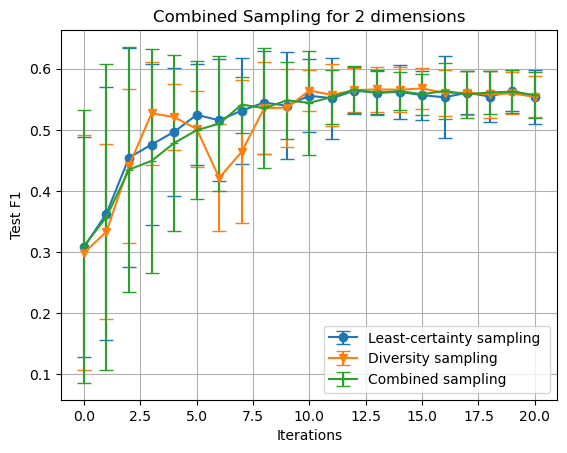

Test F1 Macro for lc: 0.5878378378378378, div: 0.581081081081081, mix: 0.5585585585585585


In [97]:
#Step 7 Compare uncertainty and diversity sampling
np.seterr(divide='ignore', invalid='ignore')
sample_factor = 0.05
N = int(1/sample_factor)
n_samples = int(unlabelled_data_all.shape[0]*sample_factor)

test_performance_lc = []
test_performance_div= []
test_performance_mix = []

#Perform active learning with different sampling starts
num_seeds = 30
for seed in range(num_seeds):
    print("seed: ",seed)
    np.random.seed(seed)
    test_accuracy_al_lc, train_data_al_lc, _ = run_al(get_unc_lc, model_all, train_data_all, unlabelled_data_all, test_data_all, n_samples, N)
    test_accuracy_al_div, train_data_al_div, _ = run_al(get_div_sgd, model_all, train_data_all, unlabelled_data_all, test_data_all, n_samples, N)
    test_accuracy_al_mix, train_data_al_mix, _ = run_al(get_unc_lc, model_all, train_data_all, unlabelled_data_all, test_data_all, n_samples, N, combine = True)

    #test_performance_lc = np.append(test_performance_lc, test_accuracy_al_lc)
    #test_performance_div = np.append(test_performance_div, test_accuracy_al_div)
    #test_performance_mix = np.append(test_performance_mix, test_accuracy_al_mix)
    test_performance_lc.append(test_accuracy_al_lc)
    test_performance_div.append(test_accuracy_al_div)
    test_performance_mix.append(test_accuracy_al_mix)

#print(test_performance_lc.shape)
#Calculate the mean and standard deviation of the data
test_performance_lc = np.vstack(test_performance_lc)
test_performance_div = np.vstack(test_performance_div)
test_performance_mix = np.vstack(test_performance_mix)


mean_lc, std_lc = mean_std(test_performance_lc)
mean_div, std_div = mean_std(test_performance_div)
mean_mix, std_mix = mean_std(test_performance_mix)

# Plotting with confidence intervals 95%

plt.errorbar(range(N+1), mean_lc, yerr=1.96 * std_lc, fmt='o-', capsize=5)
plt.errorbar(range(N+1), mean_div, yerr=1.96 * std_div, fmt='v-', capsize=5)
plt.errorbar(range(N+1), mean_mix, yerr=1.96 * std_mix, fmt='+-', capsize=5)

plt.xlabel('Iterations')
plt.ylabel('Test F1')
plt.title('Combined Sampling for 2 dimensions')
plt.legend(['Least-certainty sampling ','Diversity sampling', 'Combined sampling'])
plt.grid()
plt.show()

#Calculating the performance with the new trainingset
test_acc_lc = al_train_and_test(model_all, train_data_al_lc, test_data_all, show=False)
test_acc_div = al_train_and_test(model_all, train_data_al_div, test_data_all, show=False)
test_acc_mix = al_train_and_test(model_all, train_data_al_mix, test_data_all, show=False)

print("Test F1 Macro for lc: {}, div: {}, mix: {}".format(test_acc_lc, test_acc_div, test_acc_mix ))

# Part 3: Classification with 10 features extracted by autoencoder

## 3.1 Prepare data

In [98]:
#Step 1: Prepare the data
train_data_all, unlabelled_data_all, test_data_all = al_split_data(pd_all_features_10d, train_size= 0.01, test_size=0.20)
dev_data_all=pd.concat([train_data_all,unlabelled_data_all],axis=0)
data_list_all = ['train_data_all', 'unlabelled_data_all', 'test_data_all','dev_data_all']

# Loop over the data variables to get features and labels
for data_name in data_list_all:
    exec(f"{data_name}_X = get_features({data_name})")
    exec(f"{data_name}_y = get_label({data_name})")

## 3.2 Train a classifier with all data

In [99]:
#Step 2: Train the classifier with all data
#Train a classifier
model_all = SGDClassifier(max_iter=1000, tol=1e-3, loss='log_loss')
model_all.fit(dev_data_all_X, dev_data_all_y)
#Print the different evaluation metrics
print("Prediction on training \ndata accuracy: {},\nrecall:{},\nprecision:{},\nf1 macro: {},\nf1 micro: {} ".format(accuracy_score(dev_data_all_y, model_all.predict(dev_data_all_X)),
precision_score(dev_data_all_y, model_all.predict(dev_data_all_X),average='micro'),
recall_score(dev_data_all_y, model_all.predict(dev_data_all_X),average='micro'),
f1_score(dev_data_all_y, model_all.predict(dev_data_all_X), average ='macro'),
f1_score(dev_data_all_y, model_all.predict(dev_data_all_X), average ='micro')))

Prediction on training 
data accuracy: 0.6038374717832957,
recall:0.6038374717832957,
precision:0.6038374717832957,
f1 macro: 0.22719005383569904,
f1 micro: 0.6038374717832957 


## 3.3 Random sampling(skipped)

## 3.4 Iterative active learning(skipped)

## 3.5 Compare random sampling

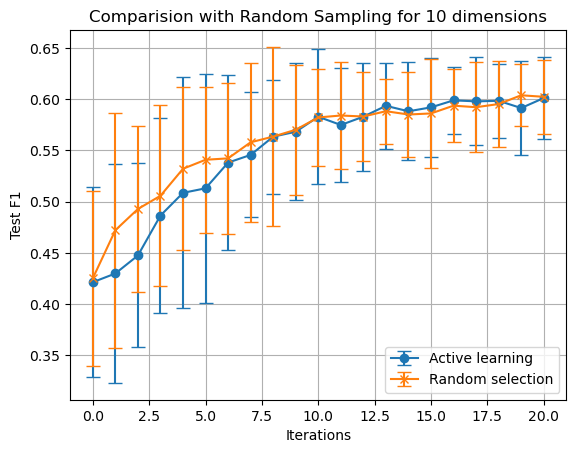

Test F1 Macro for lc: 0.5900900900900901, rand: [0.47072072072072074, 0.44819819819819817, 0.4797297297297297, 0.5022522522522522, 0.5630630630630631, 0.5495495495495496, 0.5315315315315315, 0.6058558558558559, 0.581081081081081, 0.5022522522522522, 0.5698198198198198, 0.5945945945945946, 0.6193693693693694, 0.5968468468468469, 0.5472972972972973, 0.6058558558558559, 0.5630630630630631, 0.5315315315315315, 0.5990990990990991, 0.6081081081081081, 0.6081081081081081]


In [100]:
#Step 3 skip
#Step 4 itterative active learning
#Step 5: Compare least uncertainty sampling with random sampling
np.seterr(divide='ignore', invalid='ignore')

sample_factor = 0.05
N = int(1/sample_factor)
n_samples = int(unlabelled_data_all.shape[0]*sample_factor)

test_performance_al = []
test_performance_rand = []

#Perform active learning with different sampling starts
num_seeds = 30 
for seed in range(num_seeds):
    np.random.seed(seed)
    test_accuracy_al, train_data_al, _ = run_al(get_unc_lc, model_all, train_data_all, unlabelled_data_all, test_data_all, n_samples, N)
    test_accuracy_rand, _, _ = run_random(model_all, train_data_all, unlabelled_data_all, test_data_all, n_samples, N)
    test_performance_al.append(test_accuracy_al)
    test_performance_rand.append(test_accuracy_rand)

#Calculate the mean and standard deviation of the data
mean_lc, std_lc = mean_std(test_performance_al)
mean_rand, std_rand = mean_std(test_performance_rand)

# Plotting with confidence intervals 95%
ci_lc = 1.96 * std_lc
ci_rand = 1.96 * std_rand

plt.errorbar(range(N+1), mean_lc, yerr=ci_lc, fmt='o-', capsize=5)
plt.errorbar(range(N+1), mean_rand, yerr=ci_rand, fmt='x-', capsize=5)
plt.xlabel('Iterations')
plt.ylabel('Test F1')
plt.title('Comparision with Random Sampling for 10 dimensions')
plt.legend(['Active learning','Random selection'])
plt.grid()
plt.show()

#Calculating the performance with the new trainingset
test_acc_lc = al_train_and_test(model_all, train_data_al, test_data_all, show=False)
print("Test F1 Macro for lc: {}, rand: {}".format(test_acc_lc, test_accuracy_rand ))


## 3.6 Compare different uncertainty sampling methods

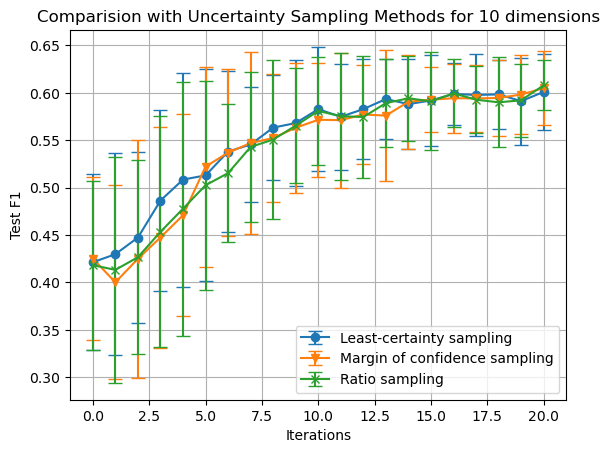

Test F1 Macro for lc: 0.5518018018018018, mc: 0.6193693693693694, rs 0.6081081081081081


In [101]:
#Step 6: Compare the different types of uncertainty sampling

test_performance_lc = []
test_performance_mc = []
test_performance_rs = []

#Perform active learning with different sampling starts

num_seeds = 30
for seed in range(num_seeds):
    np.random.seed(seed)
    test_accuracy_al_lc, train_data_al_lc, _ = run_al(get_unc_lc, model_all, train_data_all, unlabelled_data_all, test_data_all, n_samples, N)
    test_accuracy_al_mc, train_data_al_mc, _ = run_al(get_unc_mc, model_all, train_data_all, unlabelled_data_all, test_data_all, n_samples, N)
    test_accuracy_al_rs, train_data_al_rs, _ = run_al(get_unc_rs, model_all, train_data_all, unlabelled_data_all, test_data_all, n_samples, N)

    test_performance_lc.append(test_accuracy_al_lc)
    test_performance_mc.append(test_accuracy_al_mc)
    test_performance_rs.append(test_accuracy_al_rs)

#Calculate the mean and standard deviation of the data
mean_lc, std_lc = mean_std(test_performance_lc)
mean_mc, std_mc = mean_std(test_performance_mc)
mean_rs, std_rs = mean_std(test_performance_rs)

# Plotting with confidence intervals 95%
ci_lc = 1.96 * std_lc
ci_mc = 1.96 * std_mc
ci_rs = 1.96 * std_rs

plt.errorbar(range(N+1), mean_lc, yerr=ci_lc, fmt='o-', capsize=5)
plt.errorbar(range(N+1), mean_mc, yerr=ci_mc, fmt='v-', capsize=5)
plt.errorbar(range(N+1), mean_rs, yerr=ci_rs, fmt='x-', capsize=5)

plt.xlabel('Iterations')
plt.ylabel('Test F1')
plt.title('Comparision with Uncertainty Sampling Methods for 10 dimensions')
plt.legend(['Least-certainty sampling ','Margin of confidence sampling','Ratio sampling'])
plt.grid()
plt.show()

#Calculating the performance with the new trainingset
test_acc_lc = al_train_and_test(model_all, train_data_al_lc, test_data_all, show=False)
test_acc_mc = al_train_and_test(model_all, train_data_al_mc, test_data_all, show=False)
test_acc_rs = al_train_and_test(model_all, train_data_al_rs, test_data_all, show=False)
print("Test F1 Macro for lc: {}, mc: {}, rs {}".format(test_acc_lc, test_acc_mc , test_acc_rs ))

## 3.7 Compare uncertainty and diversity sampling 

seed:  0
seed:  1
seed:  2
seed:  3
seed:  4
seed:  5
seed:  6
seed:  7
seed:  8
seed:  9
seed:  10
seed:  11
seed:  12
seed:  13
seed:  14
seed:  15
seed:  16
seed:  17
seed:  18
seed:  19
seed:  20
seed:  21
seed:  22
seed:  23
seed:  24
seed:  25
seed:  26
seed:  27
seed:  28
seed:  29


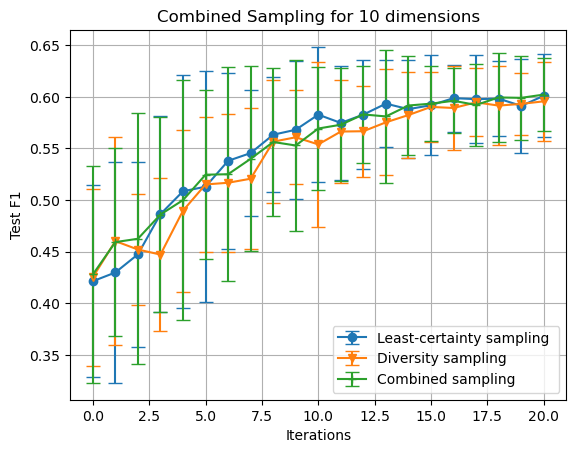

Test F1 Macro for lc: 0.5518018018018018, div: 0.5878378378378378, mix: 0.6081081081081081


In [102]:
#Step 7 Compare uncertainty and diversity sampling
np.seterr(divide='ignore', invalid='ignore')
sample_factor = 0.05
N = int(1/sample_factor)
n_samples = int(unlabelled_data_all.shape[0]*sample_factor)

test_performance_lc = []
test_performance_div= []
test_performance_mix = []

#Perform active learning with different sampling starts
num_seeds = 30
for seed in range(num_seeds):
    print("seed: ",seed)
    np.random.seed(seed)
    test_accuracy_al_lc, train_data_al_lc, _ = run_al(get_unc_lc, model_all, train_data_all, unlabelled_data_all, test_data_all, n_samples, N)
    test_accuracy_al_div, train_data_al_div, _ = run_al(get_div_sgd, model_all, train_data_all, unlabelled_data_all, test_data_all, n_samples, N)
    test_accuracy_al_mix, train_data_al_mix, _ = run_al(get_unc_lc, model_all, train_data_all, unlabelled_data_all, test_data_all, n_samples, N, combine = True)

    #test_performance_lc = np.append(test_performance_lc, test_accuracy_al_lc)
    #test_performance_div = np.append(test_performance_div, test_accuracy_al_div)
    #test_performance_mix = np.append(test_performance_mix, test_accuracy_al_mix)
    test_performance_lc.append(test_accuracy_al_lc)
    test_performance_div.append(test_accuracy_al_div)
    test_performance_mix.append(test_accuracy_al_mix)

#print(test_performance_lc.shape)
#Calculate the mean and standard deviation of the data
test_performance_lc = np.vstack(test_performance_lc)
test_performance_div = np.vstack(test_performance_div)
test_performance_mix = np.vstack(test_performance_mix)


mean_lc, std_lc = mean_std(test_performance_lc)
mean_div, std_div = mean_std(test_performance_div)
mean_mix, std_mix = mean_std(test_performance_mix)

# Plotting with confidence intervals 95%

plt.errorbar(range(N+1), mean_lc, yerr=1.96 * std_lc, fmt='o-', capsize=5)
plt.errorbar(range(N+1), mean_div, yerr=1.96 * std_div, fmt='v-', capsize=5)
plt.errorbar(range(N+1), mean_mix, yerr=1.96 * std_mix, fmt='+-', capsize=5)

plt.xlabel('Iterations')
plt.ylabel('Test F1')
plt.title('Combined Sampling for 10 dimensions')
plt.legend(['Least-certainty sampling ','Diversity sampling', 'Combined sampling'])
plt.grid()
plt.show()

#Calculating the performance with the new trainingset
test_acc_lc = al_train_and_test(model_all, train_data_al_lc, test_data_all, show=False)
test_acc_div = al_train_and_test(model_all, train_data_al_div, test_data_all, show=False)
test_acc_mix = al_train_and_test(model_all, train_data_al_mix, test_data_all, show=False)

print("Test F1 Macro for lc: {}, div: {}, mix: {}".format(test_acc_lc, test_acc_div, test_acc_mix ))

# Part 4: Classificatiion with 20 features extracted by autoencoder

## 4.1 Prepare data

In [103]:
#Step 1: Prepare the data
train_data_all, unlabelled_data_all, test_data_all = al_split_data(pd_all_features_20d, train_size= 0.01, test_size=0.20)
dev_data_all=pd.concat([train_data_all,unlabelled_data_all],axis=0)
data_list_all = ['train_data_all', 'unlabelled_data_all', 'test_data_all','dev_data_all']

# Loop over the data variables to get features and labels
for data_name in data_list_all:
    exec(f"{data_name}_X = get_features({data_name})")
    exec(f"{data_name}_y = get_label({data_name})")

## 4.2 Train a classifier with all data

In [104]:
#Step 2: Train the classifier with all data
#Train a classifier
model_all = SGDClassifier(max_iter=1000, tol=1e-3, loss='log_loss')
model_all.fit(dev_data_all_X, dev_data_all_y)
#Print the different evaluation metrics
print("Prediction on training \ndata accuracy: {},\nrecall:{},\nprecision:{},\nf1 macro: {},\nf1 micro: {} ".format(accuracy_score(dev_data_all_y, model_all.predict(dev_data_all_X)),
precision_score(dev_data_all_y, model_all.predict(dev_data_all_X),average='micro'),
recall_score(dev_data_all_y, model_all.predict(dev_data_all_X),average='micro'),
f1_score(dev_data_all_y, model_all.predict(dev_data_all_X), average ='macro'),
f1_score(dev_data_all_y, model_all.predict(dev_data_all_X), average ='micro')))

Prediction on training 
data accuracy: 0.6659142212189616,
recall:0.6659142212189616,
precision:0.6659142212189616,
f1 macro: 0.3537081724120878,
f1 micro: 0.6659142212189616 


## 4.3 Random sampling (skipped)

## 4.4  Iterative active learning (skipped)

## 4.5 Compare random sampling

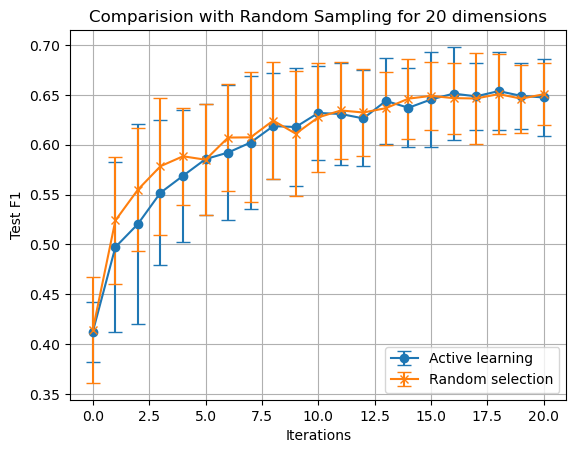

Test F1 Macro for lc: 0.6666666666666666, rand: [0.3783783783783784, 0.5765765765765766, 0.509009009009009, 0.5900900900900901, 0.5720720720720721, 0.5720720720720721, 0.5990990990990991, 0.6148648648648649, 0.6621621621621622, 0.6103603603603603, 0.6058558558558559, 0.6058558558558559, 0.6171171171171171, 0.6576576576576577, 0.6396396396396397, 0.6261261261261262, 0.6801801801801802, 0.6238738738738738, 0.6846846846846847, 0.6171171171171171, 0.6644144144144144]


In [105]:
#Step 3 skip
#Step 4 itterative active learning
#Step 5: Compare least uncertainty sampling with random sampling
np.seterr(divide='ignore', invalid='ignore')

sample_factor = 0.05
N = int(1/sample_factor)
n_samples = int(unlabelled_data_all.shape[0]*sample_factor)

test_performance_al = []
test_performance_rand = []

#Perform active learning with different sampling starts
num_seeds = 30 
for seed in range(num_seeds):
    np.random.seed(seed)
    test_accuracy_al, train_data_al, _ = run_al(get_unc_lc, model_all, train_data_all, unlabelled_data_all, test_data_all, n_samples, N)
    test_accuracy_rand, _, _ = run_random(model_all, train_data_all, unlabelled_data_all, test_data_all, n_samples, N)
    test_performance_al.append(test_accuracy_al)
    test_performance_rand.append(test_accuracy_rand)

#Calculate the mean and standard deviation of the data
mean_lc, std_lc = mean_std(test_performance_al)
mean_rand, std_rand = mean_std(test_performance_rand)

# Plotting with confidence intervals 95%
ci_lc = 1.96 * std_lc
ci_rand = 1.96 * std_rand

plt.errorbar(range(N+1), mean_lc, yerr=ci_lc, fmt='o-', capsize=5)
plt.errorbar(range(N+1), mean_rand, yerr=ci_rand, fmt='x-', capsize=5)
plt.xlabel('Iterations')
plt.ylabel('Test F1')
plt.title('Comparision with Random Sampling for 20 dimensions')
plt.legend(['Active learning','Random selection'])
plt.grid()
plt.show()

#Calculating the performance with the new trainingset
test_acc_lc = al_train_and_test(model_all, train_data_al, test_data_all, show=False)
print("Test F1 Macro for lc: {}, rand: {}".format(test_acc_lc, test_accuracy_rand ))


## 4.6 Compare different uncertainty sampling methods

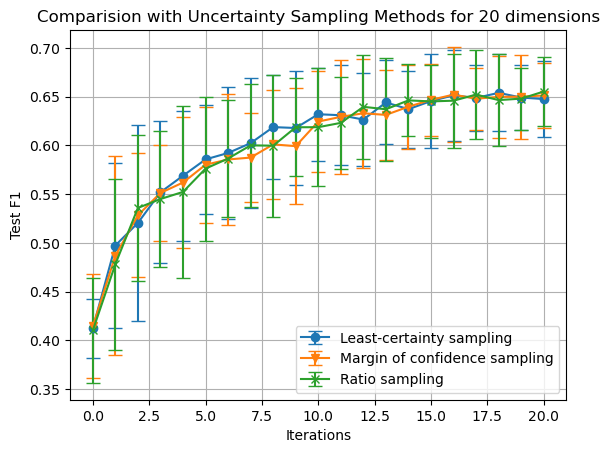

Test F1 Macro for lc: 0.6328828828828829, mc: 0.6666666666666666, rs 0.6306306306306306


In [106]:
#Step 6: Compare the different types of uncertainty sampling

test_performance_lc = []
test_performance_mc = []
test_performance_rs = []

#Perform active learning with different sampling starts

num_seeds = 30
for seed in range(num_seeds):
    np.random.seed(seed)
    test_accuracy_al_lc, train_data_al_lc, _ = run_al(get_unc_lc, model_all, train_data_all, unlabelled_data_all, test_data_all, n_samples, N)
    test_accuracy_al_mc, train_data_al_mc, _ = run_al(get_unc_mc, model_all, train_data_all, unlabelled_data_all, test_data_all, n_samples, N)
    test_accuracy_al_rs, train_data_al_rs, _ = run_al(get_unc_rs, model_all, train_data_all, unlabelled_data_all, test_data_all, n_samples, N)

    test_performance_lc.append(test_accuracy_al_lc)
    test_performance_mc.append(test_accuracy_al_mc)
    test_performance_rs.append(test_accuracy_al_rs)

#Calculate the mean and standard deviation of the data
mean_lc, std_lc = mean_std(test_performance_lc)
mean_mc, std_mc = mean_std(test_performance_mc)
mean_rs, std_rs = mean_std(test_performance_rs)

# Plotting with confidence intervals 95%
ci_lc = 1.96 * std_lc
ci_mc = 1.96 * std_mc
ci_rs = 1.96 * std_rs

plt.errorbar(range(N+1), mean_lc, yerr=ci_lc, fmt='o-', capsize=5)
plt.errorbar(range(N+1), mean_mc, yerr=ci_mc, fmt='v-', capsize=5)
plt.errorbar(range(N+1), mean_rs, yerr=ci_rs, fmt='x-', capsize=5)

plt.xlabel('Iterations')
plt.ylabel('Test F1')
plt.title('Comparision with Uncertainty Sampling Methods for 20 dimensions')
plt.legend(['Least-certainty sampling ','Margin of confidence sampling','Ratio sampling'])
plt.grid()
plt.show()

#Calculating the performance with the new trainingset
test_acc_lc = al_train_and_test(model_all, train_data_al_lc, test_data_all, show=False)
test_acc_mc = al_train_and_test(model_all, train_data_al_mc, test_data_all, show=False)
test_acc_rs = al_train_and_test(model_all, train_data_al_rs, test_data_all, show=False)
print("Test F1 Macro for lc: {}, mc: {}, rs {}".format(test_acc_lc, test_acc_mc , test_acc_rs ))

## 4.7 Compare uncertainty and diversity sampling

seed:  0
seed:  1
seed:  2
seed:  3
seed:  4
seed:  5
seed:  6
seed:  7
seed:  8
seed:  9
seed:  10
seed:  11
seed:  12
seed:  13
seed:  14
seed:  15
seed:  16
seed:  17
seed:  18
seed:  19
seed:  20
seed:  21
seed:  22
seed:  23
seed:  24
seed:  25
seed:  26
seed:  27
seed:  28
seed:  29


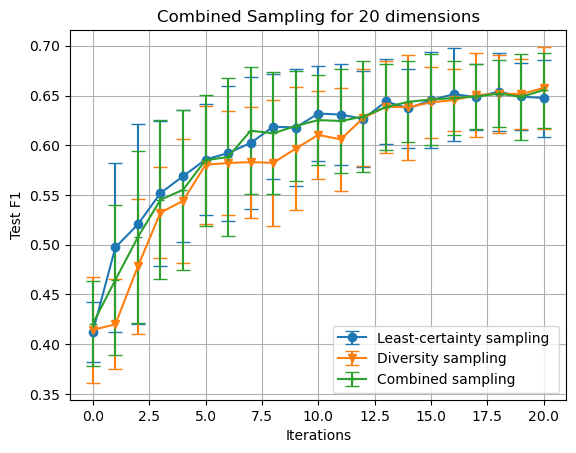

Test F1 Macro for lc: 0.668918918918919, div: 0.6396396396396397, mix: 0.6554054054054054


In [107]:
#Step 7 Compare uncertainty and diversity sampling
np.seterr(divide='ignore', invalid='ignore')
sample_factor = 0.05
N = int(1/sample_factor)
n_samples = int(unlabelled_data_all.shape[0]*sample_factor)

test_performance_lc = []
test_performance_div= []
test_performance_mix = []

#Perform active learning with different sampling starts
num_seeds = 30
for seed in range(num_seeds):
    print("seed: ",seed)
    np.random.seed(seed)
    test_accuracy_al_lc, train_data_al_lc, _ = run_al(get_unc_lc, model_all, train_data_all, unlabelled_data_all, test_data_all, n_samples, N)
    test_accuracy_al_div, train_data_al_div, _ = run_al(get_div_sgd, model_all, train_data_all, unlabelled_data_all, test_data_all, n_samples, N)
    test_accuracy_al_mix, train_data_al_mix, _ = run_al(get_unc_lc, model_all, train_data_all, unlabelled_data_all, test_data_all, n_samples, N, combine = True)
    test_performance_lc.append(test_accuracy_al_lc)
    test_performance_div.append(test_accuracy_al_div)
    test_performance_mix.append(test_accuracy_al_mix)

#print(test_performance_lc.shape)
#Calculate the mean and standard deviation of the data
test_performance_lc = np.vstack(test_performance_lc)
test_performance_div = np.vstack(test_performance_div)
test_performance_mix = np.vstack(test_performance_mix)


mean_lc, std_lc = mean_std(test_performance_lc)
mean_div, std_div = mean_std(test_performance_div)
mean_mix, std_mix = mean_std(test_performance_mix)

# Plotting with confidence intervals 95%

plt.errorbar(range(N+1), mean_lc, yerr=1.96 * std_lc, fmt='o-', capsize=5)
plt.errorbar(range(N+1), mean_div, yerr=1.96 * std_div, fmt='v-', capsize=5)
plt.errorbar(range(N+1), mean_mix, yerr=1.96 * std_mix, fmt='+-', capsize=5)

plt.xlabel('Iterations')
plt.ylabel('Test F1')
plt.title('Combined Sampling for 20 dimensions')
plt.legend(['Least-certainty sampling ','Diversity sampling', 'Combined sampling'])
plt.grid()
plt.show()

#Calculating the performance with the new trainingset
test_acc_lc = al_train_and_test(model_all, train_data_al_lc, test_data_all, show=False)
test_acc_div = al_train_and_test(model_all, train_data_al_div, test_data_all, show=False)
test_acc_mix = al_train_and_test(model_all, train_data_al_mix, test_data_all, show=False)

print("Test F1 Macro for lc: {}, div: {}, mix: {}".format(test_acc_lc, test_acc_div, test_acc_mix ))

# Part 5: Classificatiion with 512 features extracted by autoencoder

In [108]:
#Step 1: Prepare the data
train_data_all, unlabelled_data_all, test_data_all = al_split_data(pd_all_features_10d, train_size= 0.01, test_size=0.20)
dev_data_all=pd.concat([train_data_all,unlabelled_data_all],axis=0)
data_list_all = ['train_data_all', 'unlabelled_data_all', 'test_data_all','dev_data_all']

# Loop over the data variables to get features and labels
for data_name in data_list_all:
    exec(f"{data_name}_X = get_features({data_name})")
    exec(f"{data_name}_y = get_label({data_name})")

## 5.1 Prepare data

In [109]:
#Step 1: Prepare the data
train_data_all, unlabelled_data_all, test_data_all = al_split_data(pd_all_features_512d, train_size= 0.01, test_size=0.20)
dev_data_all=pd.concat([train_data_all,unlabelled_data_all],axis=0)
data_list_all = ['train_data_all', 'unlabelled_data_all', 'test_data_all','dev_data_all']

# Loop over the data variables to get features and labels
for data_name in data_list_all:
    exec(f"{data_name}_X = get_features({data_name})")
    exec(f"{data_name}_y = get_label({data_name})")

## 5.2 Train a classifier with all data

In [110]:
#Step 2: Train the classifier with all data
#Train a classifier
model_all = SGDClassifier(max_iter=1000, tol=1e-3, loss='log_loss')
model_all.fit(dev_data_all_X, dev_data_all_y)
#Print the different evaluation metrics
print("Prediction on training \ndata accuracy: {},\nrecall:{},\nprecision:{},\nf1 macro: {},\nf1 micro: {} ".format(accuracy_score(dev_data_all_y, model_all.predict(dev_data_all_X)),
precision_score(dev_data_all_y, model_all.predict(dev_data_all_X),average='micro'),
recall_score(dev_data_all_y, model_all.predict(dev_data_all_X),average='micro'),
f1_score(dev_data_all_y, model_all.predict(dev_data_all_X), average ='macro'),
f1_score(dev_data_all_y, model_all.predict(dev_data_all_X), average ='micro')))

Prediction on training 
data accuracy: 0.4785553047404063,
recall:0.4785553047404063,
precision:0.4785553047404063,
f1 macro: 0.23712042291289168,
f1 micro: 0.4785553047404063 


## 5.3 Random sampling (skipped)

## 5.4 Iterative active learning (skipped)

## 5.5 Compare random sampling

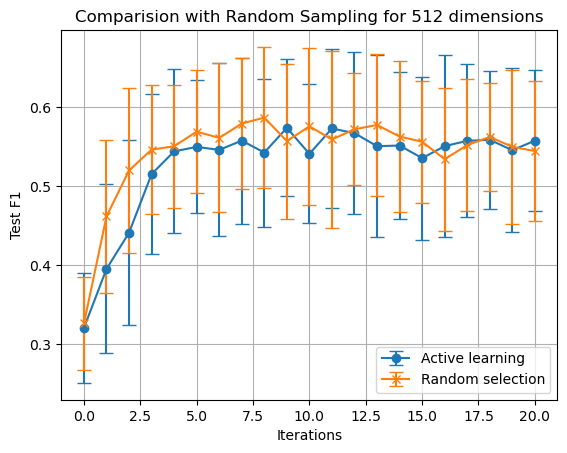

Test F1 Macro for lc: 0.5518018018018018, rand: [0.31756756756756754, 0.4617117117117117, 0.5337837837837838, 0.5337837837837838, 0.48423423423423423, 0.6036036036036037, 0.5945945945945946, 0.5135135135135135, 0.6351351351351351, 0.5630630630630631, 0.5990990990990991, 0.6306306306306306, 0.6058558558558559, 0.5472972972972973, 0.49099099099099097, 0.5495495495495496, 0.48873873873873874, 0.5315315315315315, 0.5788288288288288, 0.5833333333333334, 0.5878378378378378]


In [111]:
#Step 3 skip
#Step 4 itterative active learning
#Step 5: Compare least uncertainty sampling with random sampling
np.seterr(divide='ignore', invalid='ignore')

sample_factor = 0.05
N = int(1/sample_factor)
n_samples = int(unlabelled_data_all.shape[0]*sample_factor)

test_performance_al = []
test_performance_rand = []

#Perform active learning with different sampling starts
num_seeds = 30 
for seed in range(num_seeds):
    print("seed:",seed)
    np.random.seed(seed)
    test_accuracy_al, train_data_al, _ = run_al(get_unc_lc, model_all, train_data_all, unlabelled_data_all, test_data_all, n_samples, N)
    test_accuracy_rand, _, _ = run_random(model_all, train_data_all, unlabelled_data_all, test_data_all, n_samples, N)
    test_performance_al.append(test_accuracy_al)
    test_performance_rand.append(test_accuracy_rand)

#Calculate the mean and standard deviation of the data
mean_lc, std_lc = mean_std(test_performance_al)
mean_rand, std_rand = mean_std(test_performance_rand)

# Plotting with confidence intervals 95%
ci_lc = 1.96 * std_lc
ci_rand = 1.96 * std_rand

plt.errorbar(range(N+1), mean_lc, yerr=ci_lc, fmt='o-', capsize=5)
plt.errorbar(range(N+1), mean_rand, yerr=ci_rand, fmt='x-', capsize=5)
plt.xlabel('Iterations')
plt.ylabel('Test F1')
plt.title('Comparision with Random Sampling for 512 dimensions')
plt.legend(['Active learning','Random selection'])
plt.grid()
plt.show()

#Calculating the performance with the new trainingset
test_acc_lc = al_train_and_test(model_all, train_data_al, test_data_all, show=False)
print("Test F1 Macro for lc: {}, rand: {}".format(test_acc_lc, test_accuracy_rand ))


## 5.6 Compare different uncertainty sampling methods

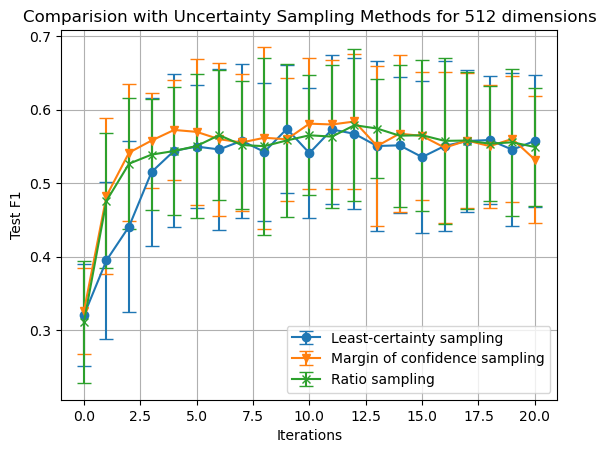

Test F1 Macro for lc: 0.5563063063063063, mc: 0.527027027027027, rs 0.5968468468468469


In [112]:
#Step 6: Compare the different types of uncertainty sampling

test_performance_lc = []
test_performance_mc = []
test_performance_rs = []

#Perform active learning with different sampling starts

num_seeds = 30
for seed in range(num_seeds):
    print("seed:",seed)
    np.random.seed(seed)
    test_accuracy_al_lc, train_data_al_lc, _ = run_al(get_unc_lc, model_all, train_data_all, unlabelled_data_all, test_data_all, n_samples, N)
    test_accuracy_al_mc, train_data_al_mc, _ = run_al(get_unc_mc, model_all, train_data_all, unlabelled_data_all, test_data_all, n_samples, N)
    test_accuracy_al_rs, train_data_al_rs, _ = run_al(get_unc_rs, model_all, train_data_all, unlabelled_data_all, test_data_all, n_samples, N)

    test_performance_lc.append(test_accuracy_al_lc)
    test_performance_mc.append(test_accuracy_al_mc)
    test_performance_rs.append(test_accuracy_al_rs)

#Calculate the mean and standard deviation of the data
mean_lc, std_lc = mean_std(test_performance_lc)
mean_mc, std_mc = mean_std(test_performance_mc)
mean_rs, std_rs = mean_std(test_performance_rs)

# Plotting with confidence intervals 95%
ci_lc = 1.96 * std_lc
ci_mc = 1.96 * std_mc
ci_rs = 1.96 * std_rs

plt.errorbar(range(N+1), mean_lc, yerr=ci_lc, fmt='o-', capsize=5)
plt.errorbar(range(N+1), mean_mc, yerr=ci_mc, fmt='v-', capsize=5)
plt.errorbar(range(N+1), mean_rs, yerr=ci_rs, fmt='x-', capsize=5)

plt.xlabel('Iterations')
plt.ylabel('Test F1')
plt.title('Comparision with Uncertainty Sampling Methods for 512 dimensions')
plt.legend(['Least-certainty sampling ','Margin of confidence sampling','Ratio sampling'])
plt.grid()
plt.show()

#Calculating the performance with the new trainingset
test_acc_lc = al_train_and_test(model_all, train_data_al_lc, test_data_all, show=False)
test_acc_mc = al_train_and_test(model_all, train_data_al_mc, test_data_all, show=False)
test_acc_rs = al_train_and_test(model_all, train_data_al_rs, test_data_all, show=False)
print("Test F1 Macro for lc: {}, mc: {}, rs {}".format(test_acc_lc, test_acc_mc , test_acc_rs ))

## 5.7 Compare uncertainty and diversity sampling

seed:  0
seed:  1
seed:  2
seed:  3
seed:  4
seed:  5
seed:  6
seed:  7
seed:  8
seed:  9
seed:  10
seed:  11
seed:  12
seed:  13
seed:  14
seed:  15
seed:  16
seed:  17
seed:  18
seed:  19
seed:  20
seed:  21
seed:  22
seed:  23
seed:  24
seed:  25
seed:  26
seed:  27
seed:  28
seed:  29


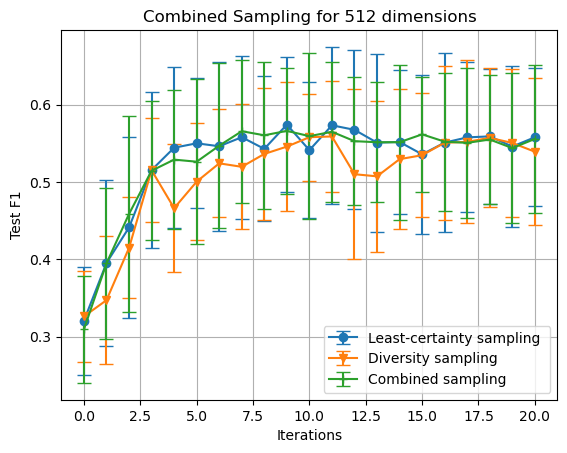

Test F1 Macro for lc: 0.5675675675675675, div: 0.6193693693693694, mix: 0.6081081081081081


In [113]:
#Step 7 Compare uncertainty and diversity sampling
np.seterr(divide='ignore', invalid='ignore')
sample_factor = 0.05
N = int(1/sample_factor)
n_samples = int(unlabelled_data_all.shape[0]*sample_factor)

test_performance_lc = []
test_performance_div= []
test_performance_mix = []

#Perform active learning with different sampling starts
num_seeds = 30
for seed in range(num_seeds):
    print("seed: ",seed)
    np.random.seed(seed)
    test_accuracy_al_lc, train_data_al_lc, _ = run_al(get_unc_lc, model_all, train_data_all, unlabelled_data_all, test_data_all, n_samples, N)
    test_accuracy_al_div, train_data_al_div, _ = run_al(get_div_sgd, model_all, train_data_all, unlabelled_data_all, test_data_all, n_samples, N)
    test_accuracy_al_mix, train_data_al_mix, _ = run_al(get_unc_lc, model_all, train_data_all, unlabelled_data_all, test_data_all, n_samples, N, combine = True)

    test_performance_lc.append(test_accuracy_al_lc)
    test_performance_div.append(test_accuracy_al_div)
    test_performance_mix.append(test_accuracy_al_mix)

#print(test_performance_lc.shape)
#Calculate the mean and standard deviation of the data
test_performance_lc = np.vstack(test_performance_lc)
test_performance_div = np.vstack(test_performance_div)
test_performance_mix = np.vstack(test_performance_mix)


mean_lc, std_lc = mean_std(test_performance_lc)
mean_div, std_div = mean_std(test_performance_div)
mean_mix, std_mix = mean_std(test_performance_mix)

# Plotting with confidence intervals 95%

plt.errorbar(range(N+1), mean_lc, yerr=1.96 * std_lc, fmt='o-', capsize=5)
plt.errorbar(range(N+1), mean_div, yerr=1.96 * std_div, fmt='v-', capsize=5)
plt.errorbar(range(N+1), mean_mix, yerr=1.96 * std_mix, fmt='+-', capsize=5)

plt.xlabel('Iterations')
plt.ylabel('Test F1')
plt.title('Combined Sampling for 512 dimensions')
plt.legend(['Least-certainty sampling ','Diversity sampling', 'Combined sampling'])
plt.grid()
plt.show()

#Calculating the performance with the new trainingset
test_acc_lc = al_train_and_test(model_all, train_data_al_lc, test_data_all, show=False)
test_acc_div = al_train_and_test(model_all, train_data_al_div, test_data_all, show=False)
test_acc_mix = al_train_and_test(model_all, train_data_al_mix, test_data_all, show=False)

print("Test F1 Macro for lc: {}, div: {}, mix: {}".format(test_acc_lc, test_acc_div, test_acc_mix ))